# Modelling using XGB Regressor

## Import libraries

In [150]:
import pandas as pd, numpy as np, time

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split, RandomizedSearchCV

# Librerías para plots
from sklearn import tree
#import graphviz
from scipy.stats import norm
from scipy.stats import t
import pylab
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from datetime import datetime, timedelta
%matplotlib inline

## Read file and prepare data 

In [151]:
df = pd.read_csv('/Users/lucas_botella/Downloads/df_covid_processed.csv')
#df = pd.read_csv('/Users/lucas_botella/Downloads/cluster_covid_data.csv')
#df=pd.read_csv('/Users/lucas_botella/Downloads/raw_deaths_covid_data.csv')
#df=pd.read_csv('/Users/lucas_botella/Downloads/cluster_per_deaths_for_model.csv')
del df['Unnamed: 0']
del df['life_expectancy']
#del df['average_deaths_2015_2019_all_ages']
#del df['month']
#del df['deaths_prev_18']
#del df['deaths']
#del df['0.0']
#del df['1.0']
#del df['2.0']
#del df['3.0']
#del df['4.0']
#df=df[df['cluster']==2]
#del df['cluster']
#df=df[df['Excess mortality P-scores, all ages Prev 18 days'] > 33]

In [152]:
df

,Code,Date,retail_and_recreation,grocery_and_pharmacy,residential,transit_stations,parks,workplaces,contact_tracing,testing_policy,...,doctors_per_1000,nurses_per_1000,beds_per_1000,number_of_arrivals,urban_population,total_vaccinations_per_100,%youth_unemployment_total,life_expectancy,"Excess mortality P-scores, all ages Prev 18 days","Excess mortality P-scores, all ages"
0,AUS,2020-03-09,0.844429,1.513714,-1.051571,6.238714,-1.572286,9.373571,2.0,1.0,...,3.75,11.92,3.84,8263000.0,85.904,NaN,11.84,82.748780,6.18,4.92
1,AUS,2020-03-16,0.979571,2.061143,-1.204286,8.938714,-0.102000,11.000000,2.0,1.0,...,3.75,11.92,3.84,8263000.0,85.904,NaN,11.84,82.748780,4.53,4.67
2,AUS,2020-03-23,1.285714,7.040857,-0.816143,8.061143,-0.816286,10.183857,2.0,1.0,...,3.75,11.92,3.84,8263000.0,85.904,NaN,11.84,82.748780,4.92,4.62
3,AUS,2020-03-30,-0.122286,10.122429,0.102000,2.061143,-1.755143,5.979571,2.0,1.0,...,3.75,11.92,3.84,8263000.0,85.904,NaN,11.84,82.748780,4.67,7.28
4,AUS,2020-04-06,-4.489857,23.734571,2.449000,-11.000000,-12.081571,5.081571,2.0,1.0,...,3.75,11.92,3.84,8263000.0,85.904,NaN,11.84,82.748780,4.62,12.13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2077,USA,2021-01-18,-25.224571,-9.775571,14.102286,-41.081571,-15.591714,-44.102000,1.0,3.0,...,2.61,11.89,2.87,75608000.0,82.058,NaN,8.30,78.539024,41.07,36.74
2078,USA,2021-01-25,-23.653143,-10.571429,12.591857,-40.000000,-20.244857,-34.122429,1.0,3.0,...,2.61,11.89,2.87,75608000.0,82.058,NaN,8.30,78.539024,44.75,33.91
2079,USA,2021-02-01,-24.387714,-11.836714,10.897857,-39.938714,-22.000000,-27.754857,1.0,3.0,...,2.61,11.89,2.87,75608000.0,82.058,0.307500,8.30,78.539024,36.74,29.53
2080,USA,2021-02-08,-25.040857,-13.693857,10.816143,-40.816429,-17.673571,-29.857143,1.0,3.0,...,2.61,11.89,2.87,75608000.0,82.058,0.913333,8.30,78.539024,33.91,24.53


In [153]:
df['nurses_per_1000']=df.apply(lambda x: x['nurses_per_1000'] if x['Excess mortality P-scores, all ages Prev 18 days'] <= 0 else 
         x['nurses_per_1000'] - (x['nurses_per_1000']*x['Excess mortality P-scores, all ages Prev 18 days']), axis=1)
df['doctors_per_1000']=df.apply(lambda x: x['doctors_per_1000'] if x['Excess mortality P-scores, all ages Prev 18 days'] <= 0 else 
         x['doctors_per_1000'] - (x['doctors_per_1000']*x['Excess mortality P-scores, all ages Prev 18 days']), axis=1)
df['beds_per_1000']=df.apply(lambda x: x['beds_per_1000'] if x['Excess mortality P-scores, all ages Prev 18 days'] <= 0 else 
         x['beds_per_1000'] - (x['beds_per_1000']*x['Excess mortality P-scores, all ages Prev 18 days']), axis=1)
df=df[df['Code']!='ECU']
df

,Code,Date,retail_and_recreation,grocery_and_pharmacy,residential,transit_stations,parks,workplaces,contact_tracing,testing_policy,...,doctors_per_1000,nurses_per_1000,beds_per_1000,number_of_arrivals,urban_population,total_vaccinations_per_100,%youth_unemployment_total,life_expectancy,"Excess mortality P-scores, all ages Prev 18 days","Excess mortality P-scores, all ages"
0,AUS,2020-03-09,0.844429,1.513714,-1.051571,6.238714,-1.572286,9.373571,2.0,1.0,...,-19.4250,-61.7456,-19.8912,8263000.0,85.904,NaN,11.84,82.748780,6.18,4.92
1,AUS,2020-03-16,0.979571,2.061143,-1.204286,8.938714,-0.102000,11.000000,2.0,1.0,...,-13.2375,-42.0776,-13.5552,8263000.0,85.904,NaN,11.84,82.748780,4.53,4.67
2,AUS,2020-03-23,1.285714,7.040857,-0.816143,8.061143,-0.816286,10.183857,2.0,1.0,...,-14.7000,-46.7264,-15.0528,8263000.0,85.904,NaN,11.84,82.748780,4.92,4.62
3,AUS,2020-03-30,-0.122286,10.122429,0.102000,2.061143,-1.755143,5.979571,2.0,1.0,...,-13.7625,-43.7464,-14.0928,8263000.0,85.904,NaN,11.84,82.748780,4.67,7.28
4,AUS,2020-04-06,-4.489857,23.734571,2.449000,-11.000000,-12.081571,5.081571,2.0,1.0,...,-13.5750,-43.1504,-13.9008,8263000.0,85.904,NaN,11.84,82.748780,4.62,12.13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2077,USA,2021-01-18,-25.224571,-9.775571,14.102286,-41.081571,-15.591714,-44.102000,1.0,3.0,...,-104.5827,-476.4323,-115.0009,75608000.0,82.058,NaN,8.30,78.539024,41.07,36.74
2078,USA,2021-01-25,-23.653143,-10.571429,12.591857,-40.000000,-20.244857,-34.122429,1.0,3.0,...,-114.1875,-520.1875,-125.5625,75608000.0,82.058,NaN,8.30,78.539024,44.75,33.91
2079,USA,2021-02-01,-24.387714,-11.836714,10.897857,-39.938714,-22.000000,-27.754857,1.0,3.0,...,-93.2814,-424.9486,-102.5738,75608000.0,82.058,0.307500,8.30,78.539024,36.74,29.53
2080,USA,2021-02-08,-25.040857,-13.693857,10.816143,-40.816429,-17.673571,-29.857143,1.0,3.0,...,-85.8951,-391.2999,-94.4517,75608000.0,82.058,0.913333,8.30,78.539024,33.91,24.53


## Including mean age and %age greater than 65 

In [154]:
df_population_gr_65=pd.read_csv('/Users/lucas_botella/Downloads/API_SP.POP.65UP.TO.ZS_DS2_en_csv_v2_2166998/API_SP.POP.65UP.TO.ZS_DS2_en_csv_v2_2166998.csv', skiprows=3)
years=df_population_gr_65.columns[54:-1]
import math
latest_values=[]

for index, row in df_population_gr_65.iterrows():
    
    aux_year=2010
    
    for year in years:
        
        if((math.isnan(row[year])==False)):
            
            aux_year=year
            
    latest_values.append(row[str(aux_year)])
df_population_gr_65['latest_value']=latest_values
df_population_gr_65=df_population_gr_65[['Country Code', 'latest_value']]
df_population_gr_65.columns=['Code', '%df_population_gr_65']
df_population_gr_65
df = pd.merge(df, df_population_gr_65, on=["Code"], how="left")
df=df[[c for c in df if c not in ['Excess mortality P-scores, all ages']] 
       + ['Excess mortality P-scores, all ages']]
df

,Code,Date,retail_and_recreation,grocery_and_pharmacy,residential,transit_stations,parks,workplaces,contact_tracing,testing_policy,...,nurses_per_1000,beds_per_1000,number_of_arrivals,urban_population,total_vaccinations_per_100,%youth_unemployment_total,life_expectancy,"Excess mortality P-scores, all ages Prev 18 days",%df_population_gr_65,"Excess mortality P-scores, all ages"
0,AUS,2020-03-09,0.844429,1.513714,-1.051571,6.238714,-1.572286,9.373571,2.0,1.0,...,-61.7456,-19.8912,8263000.0,85.904,NaN,11.84,82.748780,6.18,15.921202,4.92
1,AUS,2020-03-16,0.979571,2.061143,-1.204286,8.938714,-0.102000,11.000000,2.0,1.0,...,-42.0776,-13.5552,8263000.0,85.904,NaN,11.84,82.748780,4.53,15.921202,4.67
2,AUS,2020-03-23,1.285714,7.040857,-0.816143,8.061143,-0.816286,10.183857,2.0,1.0,...,-46.7264,-15.0528,8263000.0,85.904,NaN,11.84,82.748780,4.92,15.921202,4.62
3,AUS,2020-03-30,-0.122286,10.122429,0.102000,2.061143,-1.755143,5.979571,2.0,1.0,...,-43.7464,-14.0928,8263000.0,85.904,NaN,11.84,82.748780,4.67,15.921202,7.28
4,AUS,2020-04-06,-4.489857,23.734571,2.449000,-11.000000,-12.081571,5.081571,2.0,1.0,...,-43.1504,-13.9008,8263000.0,85.904,NaN,11.84,82.748780,4.62,15.921202,12.13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021,USA,2021-01-18,-25.224571,-9.775571,14.102286,-41.081571,-15.591714,-44.102000,1.0,3.0,...,-476.4323,-115.0009,75608000.0,82.058,NaN,8.30,78.539024,41.07,16.209606,36.74
2022,USA,2021-01-25,-23.653143,-10.571429,12.591857,-40.000000,-20.244857,-34.122429,1.0,3.0,...,-520.1875,-125.5625,75608000.0,82.058,NaN,8.30,78.539024,44.75,16.209606,33.91
2023,USA,2021-02-01,-24.387714,-11.836714,10.897857,-39.938714,-22.000000,-27.754857,1.0,3.0,...,-424.9486,-102.5738,75608000.0,82.058,0.307500,8.30,78.539024,36.74,16.209606,29.53
2024,USA,2021-02-08,-25.040857,-13.693857,10.816143,-40.816429,-17.673571,-29.857143,1.0,3.0,...,-391.2999,-94.4517,75608000.0,82.058,0.913333,8.30,78.539024,33.91,16.209606,24.53


In [155]:
X=df[df.columns[2:-1]]
y=df['Excess mortality P-scores, all ages']

In [156]:
X.head()

,retail_and_recreation,grocery_and_pharmacy,residential,transit_stations,parks,workplaces,contact_tracing,testing_policy,international_travel_controls,restrictions_internal_movements,...,doctors_per_1000,nurses_per_1000,beds_per_1000,number_of_arrivals,urban_population,total_vaccinations_per_100,%youth_unemployment_total,life_expectancy,"Excess mortality P-scores, all ages Prev 18 days",%df_population_gr_65
0,0.844429,1.513714,-1.051571,6.238714,-1.572286,9.373571,2.0,1.0,3.000000,0.000000,...,-19.4250,-61.7456,-19.8912,8263000.0,85.904,NaN,11.84,82.74878,6.18,15.921202
1,0.979571,2.061143,-1.204286,8.938714,-0.102000,11.000000,2.0,1.0,3.000000,0.000000,...,-13.2375,-42.0776,-13.5552,8263000.0,85.904,NaN,11.84,82.74878,4.53,15.921202
2,1.285714,7.040857,-0.816143,8.061143,-0.816286,10.183857,2.0,1.0,3.000000,0.000000,...,-14.7000,-46.7264,-15.0528,8263000.0,85.904,NaN,11.84,82.74878,4.92,15.921202
3,-0.122286,10.122429,0.102000,2.061143,-1.755143,5.979571,2.0,1.0,3.000000,0.000000,...,-13.7625,-43.7464,-14.0928,8263000.0,85.904,NaN,11.84,82.74878,4.67,15.921202
4,-4.489857,23.734571,2.449000,-11.000000,-12.081571,5.081571,2.0,1.0,3.428571,1.142857,...,-13.5750,-43.1504,-13.9008,8263000.0,85.904,NaN,11.84,82.74878,4.62,15.921202


In [157]:
X.columns

Index(['retail_and_recreation', 'grocery_and_pharmacy', 'residential',
       'transit_stations', 'parks', 'workplaces', 'contact_tracing',
       'testing_policy', 'international_travel_controls',
       'restrictions_internal_movements', 'close_public_transport',
       'public_information_campaigns', 'facial_coverings',
       'stay_home_requirements', 'restriction_gatherings',
       'cancel_public_events', 'workplace_closures', 'school_closures',
       'debt_relief', 'income_support', 'Holiday', 'temp', 'prcp',
       'doctors_per_1000', 'nurses_per_1000', 'beds_per_1000',
       'number_of_arrivals', 'urban_population', 'total_vaccinations_per_100',
       '%youth_unemployment_total', 'life_expectancy',
       'Excess mortality P-scores, all ages Prev 18 days',
       '%df_population_gr_65'],
      dtype='object')

## Apply model and view results 

pip install xgboost

In [158]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV, train_test_split
from xgboost import XGBRegressor

## XGBoost Regressor 

### GridSearchCV 

In [159]:
import warnings
warnings.filterwarnings('ignore')

In [160]:
# A parameter grid for XGBoost
params = {'min_child_weight':[4,5], 'gamma':[i/10.0 for i in range(3,6)],  'subsample':[i/10.0 for i in range(6,11)],
'colsample_bytree':[i/10.0 for i in range(6,11)], 'max_depth': [2,3,4]}

# Initialize XGB and GridSearch
xgb = XGBRegressor(nthread=-1) 

grid = GridSearchCV(xgb, params, verbose=1)

In [161]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

In [162]:
%%time
grid.fit(X_train, y_train)

Fitting 5 folds for each of 450 candidates, totalling 2250 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2250 out of 2250 | elapsed:  9.3min finished


CPU times: user 8min 36s, sys: 5.55 s, total: 8min 41s
Wall time: 9min 19s


GridSearchCV(estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=100, n_jobs=None, nthread=-1,
                                    num_parallel_tree=None, random_state=None,
                                    reg_alpha=None, reg_lambda=None,
                                    scale_pos_weight=None, subsample=None,
                                    tree_method=None, validate_parameters=

In [163]:
grid.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1.0, gamma=0.3, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=4,
             min_child_weight=5, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=-1, nthread=-1, num_parallel_tree=1,
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             subsample=1.0, tree_method='exact', validate_parameters=1,
             verbosity=None)

## Model evaluation metrics

### Test Set

In [165]:
y_pred=grid.best_estimator_.predict(X_test)

In [166]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
mape=np.mean(np.abs((y_test - y_pred) / y_test)) * 100

scores = {'mae': mae, 'mse': mse, 'rmse': rmse, 'r2': r2, 'mape':mape}

for key in scores:
    print(f"{key} score is {scores[key]}")

mae score is 7.867816653461441
mse score is 135.70052999311451
rmse score is 11.649057043087845
r2 score is 0.7557739065441177
mape score is inf


### Train Set

In [167]:
y_pred_train=grid.best_estimator_.predict(X_train)

In [168]:
mae = mean_absolute_error(y_train, y_pred_train)
mse = mean_squared_error(y_train, y_pred_train)
rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
r2 = r2_score(y_train, y_pred_train)

scores = {'mae': mae, 'mse': mse, 'rmse': rmse, 'r2': r2}

for key in scores:
    print(f"{key} score is {scores[key]}")

mae score is 2.6845518362017713
mse score is 13.441943718792938
rmse score is 3.6663256427645563
r2 score is 0.9751221299220543


### Test Set Predictions 

In [169]:
df_eval = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df_eval['Difference']=np.abs(df_eval['Actual']-df_eval['Predicted'])
#df_eval=df_eval.sort_values('Difference')
df_eval

,Actual,Predicted,Difference
1027,65.10,71.203712,6.103712
1463,23.72,25.136465,1.416465
1709,11.83,21.411280,9.581280
1686,7.25,17.482956,10.232956
239,7.86,7.764387,0.095613
...,...,...,...
641,-3.00,12.205009,15.205009
1786,-0.94,1.969429,2.909429
712,16.37,-2.509861,18.879861
1857,8.68,1.385240,7.294760


In [200]:
#mape corrected
df_eval.Difference.sum()/df_eval.Actual.sum()

0.5532494365078484

## Model evaluation plots

Text(0.5, 1.0, 'Difference Histogram')

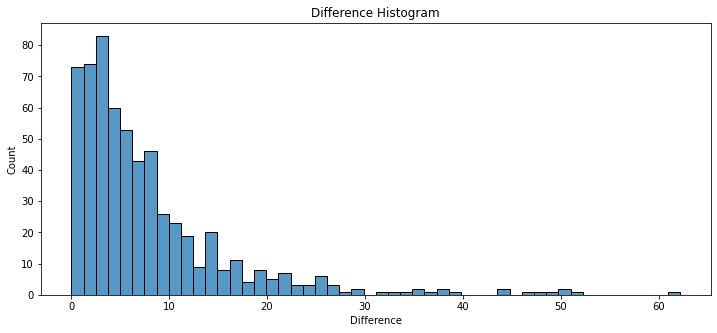

In [171]:
# plot difference hist
f, axes = plt.subplots(figsize=(12,5))
sns.histplot(x='Difference', data=df_eval, kde=False, bins=50, ax=axes);
axes.set_title('Difference Histogram')

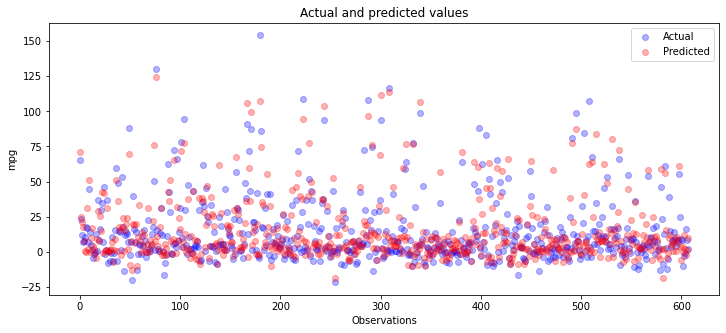

In [172]:
import matplotlib.pyplot as plt

_, ax = plt.subplots(figsize=(12,5))

ax.scatter(x = range(0, y_test.size), y=y_test, c = 'blue', label = 'Actual', alpha = 0.3)
ax.scatter(x = range(0, y_pred.size), y=y_pred, c = 'red', label = 'Predicted', alpha = 0.3)

plt.title('Actual and predicted values')
plt.xlabel('Observations')
plt.ylabel('mpg')
plt.legend()
plt.show()

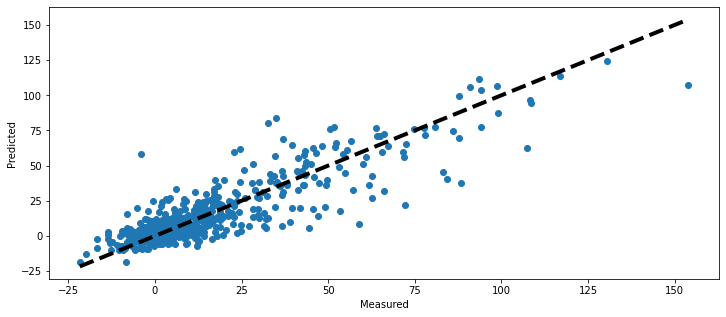

In [173]:
# cross_val_predict returns an array of the same size as `y` where each entry
# is a prediction obtained by cross validation:

fig, ax = plt.subplots(figsize=(12,5))
ax.scatter(y_test, y_pred)
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

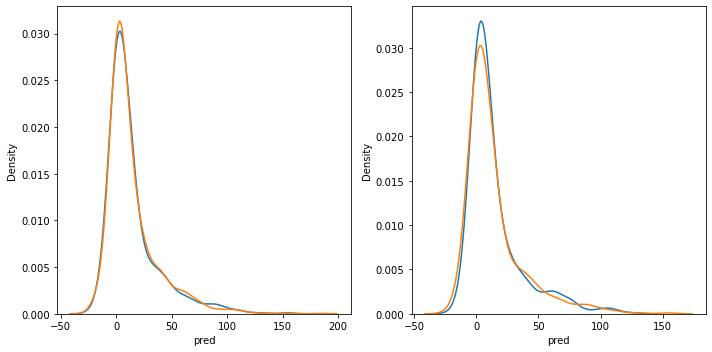

In [174]:
import seaborn as sns
# Hacemos las predicciones y evaluamos los resultados graficamente, tanto en el set de Train como de Test
y_test_pred = y_pred
y_train_pred = y_test

test = y_test
train = y_train

res_df_test = pd.DataFrame({'pred': y_test_pred, 'test': test})
res_df_test['dif'] = np.round(res_df_test['pred']-res_df_test['test'],2)
res_df_test['dif_abs'] = np.round(np.abs(res_df_test['pred']-res_df_test['test']),2)
res_df_test['dif%'] = np.round(100*(res_df_test['pred']-res_df_test['test'])/res_df_test['test'],2)

res_df_train = pd.DataFrame({'pred': y_train_pred, 'test': train})
res_df_train['dif'] = np.round(res_df_train['pred']-res_df_train['test'],2)
res_df_train['dif_abs'] = np.round(np.abs(res_df_train['pred']-res_df_train['test']),2)
res_df_train['dif%'] = np.round(100*(res_df_train['pred']-res_df_train['test'])/res_df_train['test'],2)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
plot = sns.kdeplot(res_df_train['pred'], ax=axes[0])
plot = sns.kdeplot(res_df_train['test'], ax=axes[0])
plot = sns.kdeplot(res_df_test['pred'], ax=axes[1])
plot = sns.kdeplot(res_df_test['test'], ax=axes[1])
fig.tight_layout()

In [175]:
res_df_test['dif_abs'].sum()/res_df_test['test'].sum()

0.5532422051644436

In [208]:
(res_df_test['test'].sum()-res_df_test['pred'].sum())/res_df_test['test'].sum()

-0.02617315759220854

In [176]:
mae_test = np.round(res_df_test['dif_abs'].mean(),2)
gae_test = np.round(res_df_test['dif_abs'].sum(),2)
error_test_rate_abs = np.round(100*gae_test/res_df_test['test'].sum(),2)
error_test = np.round(res_df_test['dif'].sum(),2)
error_test_rate = np.round(100*error_test/res_df_test['test'].sum(),2)
print('El error absoluto medio es: ', mae_test)
print('El error global es: ', error_test)
print('La tasa de error global es: %',error_test_rate)

El error absoluto medio es:  7.87
El error global es:  226.31
La tasa de error global es: % 2.62


In [177]:
res_df_test.sort_values('dif%')

,pred,test,dif,dif_abs,dif%
21,-6.000720,0.01,-6.01,6.01,-60107.20
1037,7.989240,-0.02,8.01,8.01,-40046.20
809,7.519202,-0.02,7.54,7.54,-37696.01
1186,9.990644,-0.06,10.05,10.05,-16751.07
1797,3.541369,-0.04,3.58,3.58,-8953.42
...,...,...,...,...,...
726,5.888384,0.26,5.63,5.63,2164.76
148,10.531967,0.31,10.22,10.22,3297.41
1540,11.933429,0.22,11.71,11.71,5324.29
1323,4.018953,0.00,4.02,4.02,inf


In [178]:
res_df_test['dif%'].mean()

inf

In [179]:
df['Excess mortality P-scores, all ages'].describe()

count    2026.000000
mean       14.135938
std        23.349225
min       -24.090000
25%         0.250000
50%         6.600000
75%        19.142500
max       183.310000
Name: Excess mortality P-scores, all ages, dtype: float64

In [180]:
res_df_test['dif%'].describe()

count      608.0000
mean            inf
std             NaN
min     -60107.2000
25%        -74.5825
50%        -18.9700
75%         38.1250
max             inf
Name: dif%, dtype: float64

## Feature importance 

In [181]:
import xgboost
from xgboost import plot_importance
from xgboost import plot_tree

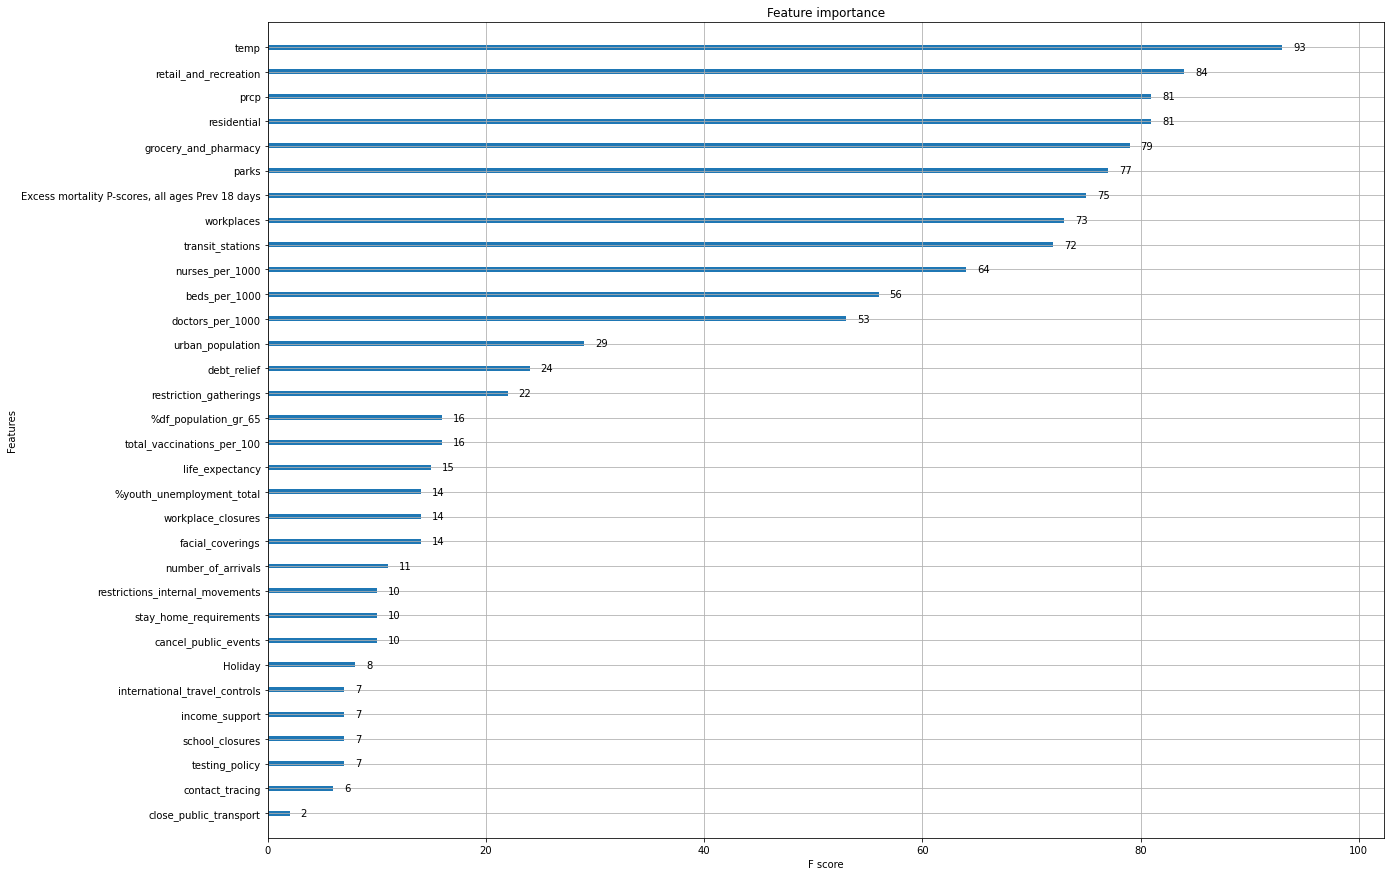

In [183]:
xgboost.plot_importance(grid.best_estimator_)
plt.rcParams['figure.figsize'] = [20, 15]
plt.show()

# Chronological evaluation

### Splitting data temporarly

In [184]:
split_date = pd.datetime(2021,1,11)

df_training = df.loc[pd.to_datetime(df['Date']) <= split_date]
df_test = df.loc[pd.to_datetime(df['Date']) > split_date]

In [185]:
X=df_training[df.columns[2:-1]]
y=df_training[df.columns[-1]]

In [186]:
%%time
grid.fit(X, y)

Fitting 5 folds for each of 450 candidates, totalling 2250 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


CPU times: user 9min 20s, sys: 4.05 s, total: 9min 24s
Wall time: 9min 51s


[Parallel(n_jobs=1)]: Done 2250 out of 2250 | elapsed:  9.9min finished


GridSearchCV(estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=100, n_jobs=None, nthread=-1,
                                    num_parallel_tree=None, random_state=None,
                                    reg_alpha=None, reg_lambda=None,
                                    scale_pos_weight=None, subsample=None,
                                    tree_method=None, validate_parameters=

In [187]:
X_test=df_test[df_test.columns[2:-1]]
y_test=df_test[df_test.columns[-1]]

In [188]:
y_pred=grid.best_estimator_.predict(X_test)

In [189]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

scores = {'mae': mae, 'mse': mse, 'rmse': rmse, 'r2': r2}

for key in scores:
    print(f"{key} score is {scores[key]}")

mae score is 14.210388908175354
mse score is 342.82991641719263
rmse score is 18.515666782948774
r2 score is 0.48788093269184407
